In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import (
    read_csv_from_web,
    implementPairDecayLimit,
    fromHB5Table1,
)
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions
from Higgs.tools.LimitValidation import validateChannelLimit, validateChannelWidthLimit

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution

mmu = 105.6583715e-3
mtau = 1.77682


# ATLAS 8 TeV

## `gg -> H125 -> a a -> mumutautau` [1505.01609](https://arxiv.org/abs/1505.01609)

The limit is set on `BR(tautau)^2` assuming the mass relation between mumu and tautau BRs.

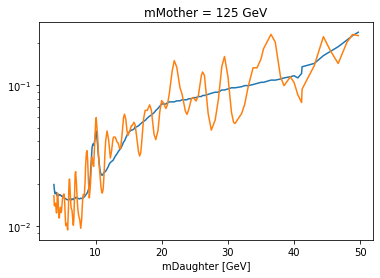

Looks good. Saving this to ggh125_LHC8_ATLAS_20.json


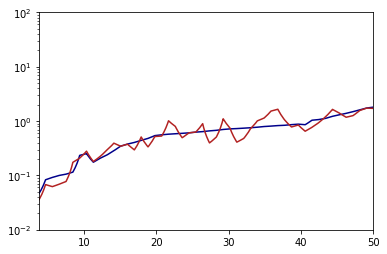

In [3]:
df = pd.read_csv("data/1505_01609_Fig6top.csv")
df["mMother"] = 125

ref = HP.SMHiggs(125)
refCxn = ref.cxn("LHC8", "ggH")
df.obs *= refCxn
df.exp *= refCxn

# convert one power of BR(tautau) into BR(mumu) using Eq. 1
brRatioMuTau = mmu ** 2 / mtau ** 2 / np.sqrt(1 - (2 * mtau / df.mDaughter1) ** 2)
df.obs *= brRatioMuTau * 2  # different symmetry factor
df.exp *= brRatioMuTau * 2  # different symmetry factor


limitFile = implementPairDecayLimit(
    "1505.01609",
    {
        "production": ["ggH"],  # b-veto
        "firstDecay": ["mumu"],
        "secondDecay": ["tautau"],
    },
    "Fig.6 (top)",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 20,
            "relative": 0,
        },
    },
    idSuffix=1,
    prefix="ggh125",
    constraints={
        "firstDaughter": [
            {"mumuTautauRatio": "odd"}
        ],  # mixed mumu/tautau contributions
    },
)
lim = HB.Limit(limitFile)


pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setDecayWidth("mumu", 0.1)
hh.setMass(125)

hm = np.linspace(3.75, 50)
r = np.logspace(-2, 2)


def testAgainstLimit(mass, rate):
    h1.setMass(mass)
    h1.setDecayWidth(
        "tautau",
        mtau ** 2
        / mmu ** 2
        * np.sqrt(1 - (2 * mtau / h1.mass()) ** 2)
        * h1.br("mumu")
        * h1.totalWidth(),
    )
    hh.setCxn("LHC8", "ggH", rate * refCxn / h1.br("tautau") ** 2)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(
    hm,
    r,
    expR,
    levels=[1],
    colors=["darkblue"],
)
obsCc = ax.contour(
    hm,
    r,
    obsR,
    levels=[1],
    colors=["firebrick"],
)
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale("log")


## `gg -> H -> a a -> mumutautau` (ma = 5 GeV) [1505.01609](https://arxiv.org/abs/1505.01609)

The limit is set on `BR(tautau)^2` assuming the mass relation between mumu and tautau BRs.

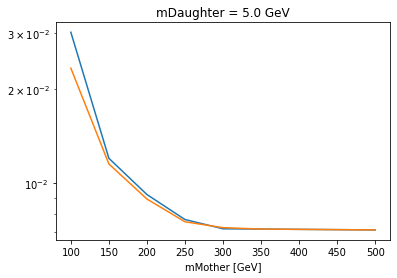

Looks good. Saving this to ggH_LHC8_ATLAS_20.json


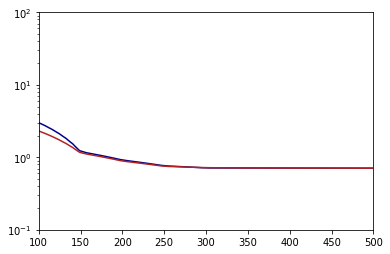

In [4]:
df = pd.DataFrame(
    data={
        "mMother": np.concatenate([np.arange(100, 550, 50)]),
        "obs": [
            2.3132,
            1.1475,
            0.88747,
            0.75133,
            0.71958,
            0.71223,
            0.71076,
            0.70930,
            0.70784,
        ],
        "exp": [
            3.0096,
            1.1957,
            0.91715,
            0.76379,
            0.71369,
            0.71223,
            0.71076,
            0.70930,
            0.70784,
        ],
    }
)

df["mDaughter1"] = 5.0
# convert one power of BR(tautau) into BR(mumu) using Eq. 1
brRatioMuTau = mmu ** 2 / mtau ** 2 / np.sqrt(1 - (2 * mtau / df.mDaughter1) ** 2)
df.obs *= brRatioMuTau * 2  # different symmetry factor (same decay vs distinct decays)
df.exp *= brRatioMuTau * 2  # different symmetry factor (same decay vs distinct decays)

limitFile = implementPairDecayLimit(
    "1505.01609",
    {
        "production": ["ggH"],
        "firstDecay": ["mumu"],
        "secondDecay": ["tautau"],
    },
    "Fig.6 (bottom)",
    df,
    massResolution={
        "firstDaughter": resolution.mumu["light"],
        "secondDaughter": resolution.tautau["default"],
        "mother": {
            "absolute": 20,
            "relative": 0,
        },
    },
    constraints={
        "firstDaughter": [
            {"mumuTautauRatio": "odd"}
        ],  # mixed mumu/tautau contributions
    },
    idSuffix=2,
)
lim = HB.Limit(limitFile)


pred = Predictions()
hh = pred.addParticle(HP.NeutralScalar("hh"))
h1 = pred.addParticle(HP.NeutralScalar("h1"))
hh.setDecayWidth("h1", "h1", 1.0)
h1.setMass(5)
h1.setDecayWidth("mumu", 1.0)
h1.setDecayWidth(
    "tautau",
    mtau ** 2
    / mmu ** 2
    * np.sqrt(1 - (2 * mtau / h1.mass()) ** 2)
    * h1.br("mumu")
    * h1.totalWidth(),
)

hm = np.linspace(100, 500)
r = np.logspace(-1, 2)


def testAgainstLimit(mass, rate):
    hh.setMass(mass)
    hh.setCxn("LHC8", "ggH", rate / h1.br("tautau") ** 2)
    app = lim.apply(pred)
    if len(app) == 0:
        print("Limit not applied for ", mass, rate)
        return (0, 0)
    return (app[0].expRatio(), app[0].obsRatio())


test = np.frompyfunc(testAgainstLimit, 2, 2)
XX, YY = np.meshgrid(hm, r)
expR, obsR = test(XX, YY)
fig, ax = plt.subplots()
expCc = ax.contour(hm, r, expR, levels=[1], colors=["darkblue"])
obsCc = ax.contour(hm, r, obsR, levels=[1], colors=["firebrick"])
expCc.collections[0].set_label("expRatio = 1")
obsCc.collections[0].set_label("obsRatio = 1")
ax.set_yscale("log")
